# Población mensual por comuna

In [ ]:
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib
#!pip install scikit-learn
#!pip install --upgrade pip

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('Poblacion_CENSO.xlsx', sheet_name='Hoja1')

In [3]:
df = df.drop(columns=["Región"])
df.head(3)

Comuna  2024-06-01 00:00:00  2017-06-01 00:00:00  \
0             BUIN               116969                96614   
1  CALERA DE TANGO                25491                25392   
2        CERRILLOS                85041                80832   

   2002-06-01 00:00:00  1992-06-01 00:00:00  
0                63419                52792  
1                18235                11843  
2                71906                72649

In [ ]:
df_long = df.melt(id_vars='Comuna', var_name='anio', value_name='poblacion')
aux_comp = df_long.copy()
aux_comp["anio"] = aux_comp["anio"].apply(lambda x: x.strftime('%Y-%m'))
df_long['anio'] = df_long['anio'].apply(lambda x: x.year)
fechas = pd.date_range(start="1992-01-01",
                       end="2029-12-01",
                       freq="MS")

results = []
for comuna, grupo in df_long.groupby('Comuna'):
    # X: años, y: población
    X = grupo['anio'].values.reshape(-1, 1)
    y = grupo['poblacion'].values

    # Regresión polinómica grado 2 (puedes ajustar el grado)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predecimos para todos los meses desde 1992 a 2025
    for fecha in fechas:
        year_decimal = fecha.year + (fecha.month - 1) / 12
        X_pred = poly.transform([[year_decimal]])
        y_pred = model.predict(X_pred)[0]

        results.append({
            'comuna': comuna,
            'fecha': fecha.strftime('%Y-%m'),
            'poblacion_estimada': y_pred
        })

# Convertimos a DataFrame final
df_result = pd.DataFrame(results)

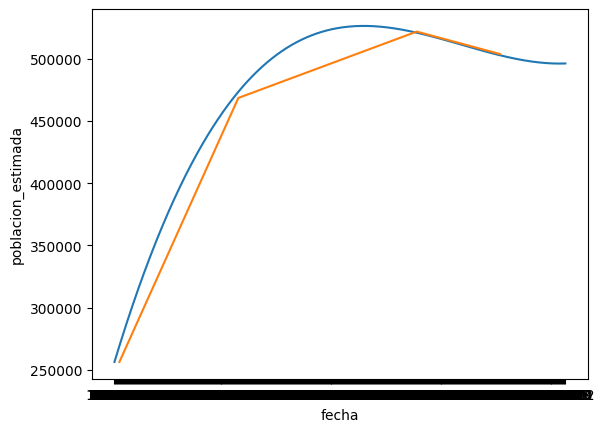

In [10]:
# Plot the data
comuna = 'MAIPU'
sns.lineplot(data=df_result[df_result['comuna'] == comuna], x='fecha', y='poblacion_estimada')
sns.lineplot(data=aux_comp[aux_comp["Comuna"] == comuna], x='anio', y='poblacion')

plt.show()

In [6]:
df_result.to_excel('poblacion_estimada.xlsx', index=False)

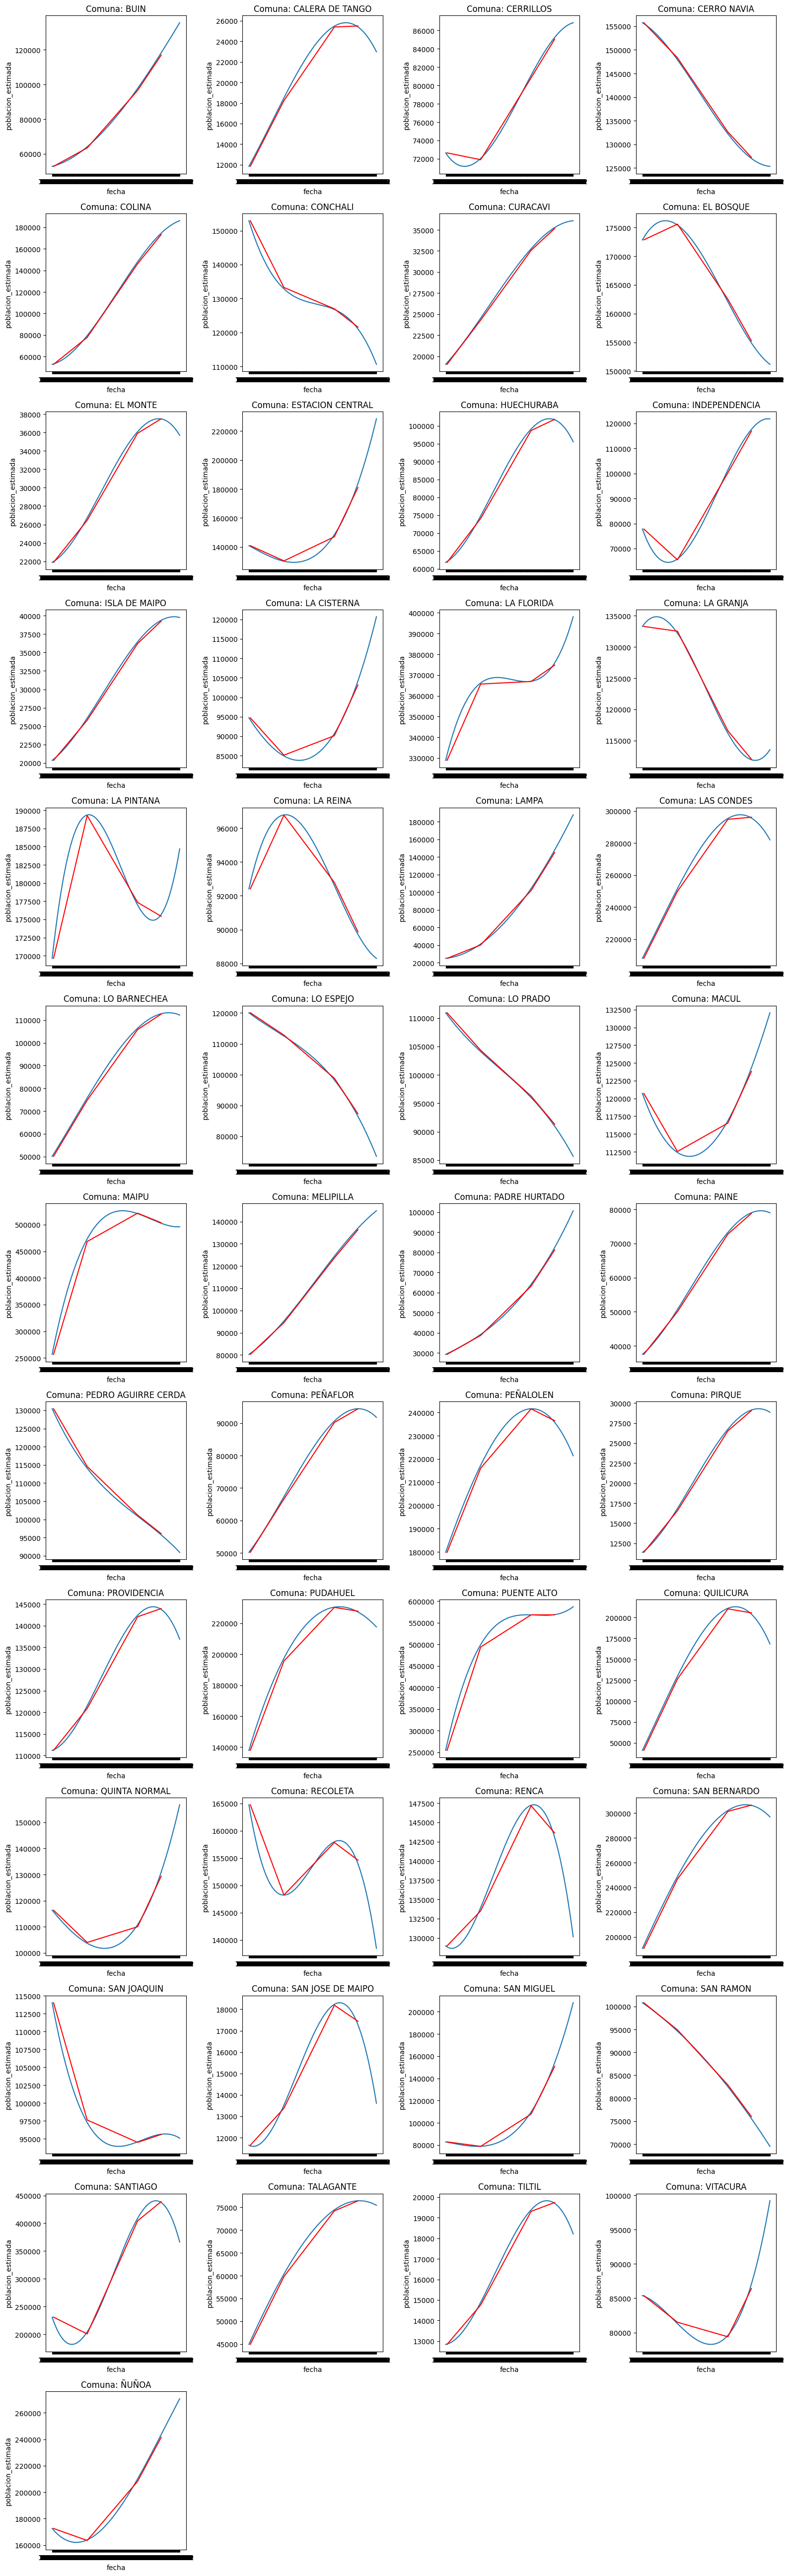

In [9]:
# Obtener las comunas únicas
comunas = df_result['comuna'].unique()

# Definir el número de gráficos por fila
graficos_por_fila = 4

# Calcular el número de filas necesarias
num_filas = -(-len(comunas) // graficos_por_fila)  # División redondeada hacia arriba

# Crear una figura con subgráficos
fig, axes = plt.subplots(num_filas, graficos_por_fila, figsize=(16, 4 * num_filas))
axes = axes.flatten()  # Convertir a una lista plana para iterar fácilmente

# Iterar sobre las comunas y los ejes
for i, (comuna, ax) in enumerate(zip(comunas, axes)):

    # Graficar la serie de tiempo
    sns.lineplot(data=df_result[df_result['comuna'] == comuna], x='fecha', y='poblacion_estimada', ax=ax)
    sns.lineplot(data=aux_comp[aux_comp["Comuna"] == comuna], x='anio', y='poblacion', ax=ax, color='red')
    ax.set_title(f"Comuna: {comuna}")
    

# Ocultar los ejes no utilizados si hay más subgráficos que comunas
for ax in axes[len(comunas):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Proyección de clientes

## Censo interpolado

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

In [60]:
df_proyecciones_ine = pd.read_excel('estimaciones-y-proyecciones-2002-2035.xlsx', sheet_name='EEPP comuna área')

In [62]:
# Filtrar solo las filas de la Región Metropolitana
df_filtrado = df_proyecciones_ine

# Seleccionar únicamente 'Nombre Comuna' y columnas de población
columnas_poblacion = ['Nombre Comuna'] + [col for col in df_proyecciones_ine.columns if col.startswith('Poblacion')]
df_filtrado = df_filtrado[columnas_poblacion]

# Agrupar por 'Nombre Comuna' y sumar las columnas de población
df_agrupado = df_filtrado.groupby('Nombre Comuna', as_index=False).sum()

In [63]:
# Formatear datos anuales a largo
df_anual = df_agrupado.melt(id_vars='Nombre Comuna',
                            var_name='Año',
                            value_name='Poblacion')
df_anual['Año'] = df_anual['Año'].str.extract(r'(\d+)').astype(int)

# Generar un índice mensual para cada comuna
df_mensual_interp = pd.DataFrame()

for comuna in df_anual['Nombre Comuna'].unique():
    datos_comuna = df_anual[df_anual['Nombre Comuna'] == comuna].copy()

    # Crear índice temporal con fecha el 1ro de enero de cada año
    datos_comuna['Fecha'] = pd.to_datetime(dict(year=datos_comuna['Año'], month=1, day=1))
    datos_comuna = datos_comuna.set_index('Fecha').sort_index()

    # Reindexar a frecuencia mensual
    fechas_mensuales = pd.date_range(start=datos_comuna.index.min(), 
                                     end=datos_comuna.index.max() + pd.DateOffset(years=1) - pd.DateOffset(months=1),
                                     freq='MS')
    datos_mensual = datos_comuna.reindex(fechas_mensuales)
    datos_mensual['Nombre Comuna'] = comuna

    # Interpolación lineal mensual
    datos_mensual['Poblacion'] = datos_mensual['Poblacion'].interpolate(method='linear')

    # Guardar resultados
    datos_mensual = datos_mensual.reset_index().rename(columns={'index': 'Fecha'})
    datos_mensual['Año'] = datos_mensual['Fecha'].dt.year
    datos_mensual['Mes'] = datos_mensual['Fecha'].dt.month
    df_mensual_interp = pd.concat([df_mensual_interp, datos_mensual], ignore_index=True)


In [64]:
df_mensual_interp

Fecha Nombre Comuna   Año      Poblacion  Mes
0      2002-01-01     Algarrobo  2002    9043.000000    1
1      2002-02-01     Algarrobo  2002    9075.333333    2
2      2002-03-01     Algarrobo  2002    9107.666667    3
3      2002-04-01     Algarrobo  2002    9140.000000    4
4      2002-05-01     Algarrobo  2002    9172.333333    5
...           ...           ...   ...            ...  ...
141163 2035-08-01         Ñuñoa  2035  309128.000000    8
141164 2035-09-01         Ñuñoa  2035  309128.000000    9
141165 2035-10-01         Ñuñoa  2035  309128.000000   10
141166 2035-11-01         Ñuñoa  2035  309128.000000   11
141167 2035-12-01         Ñuñoa  2035  309128.000000   12

[141168 rows x 5 columns]

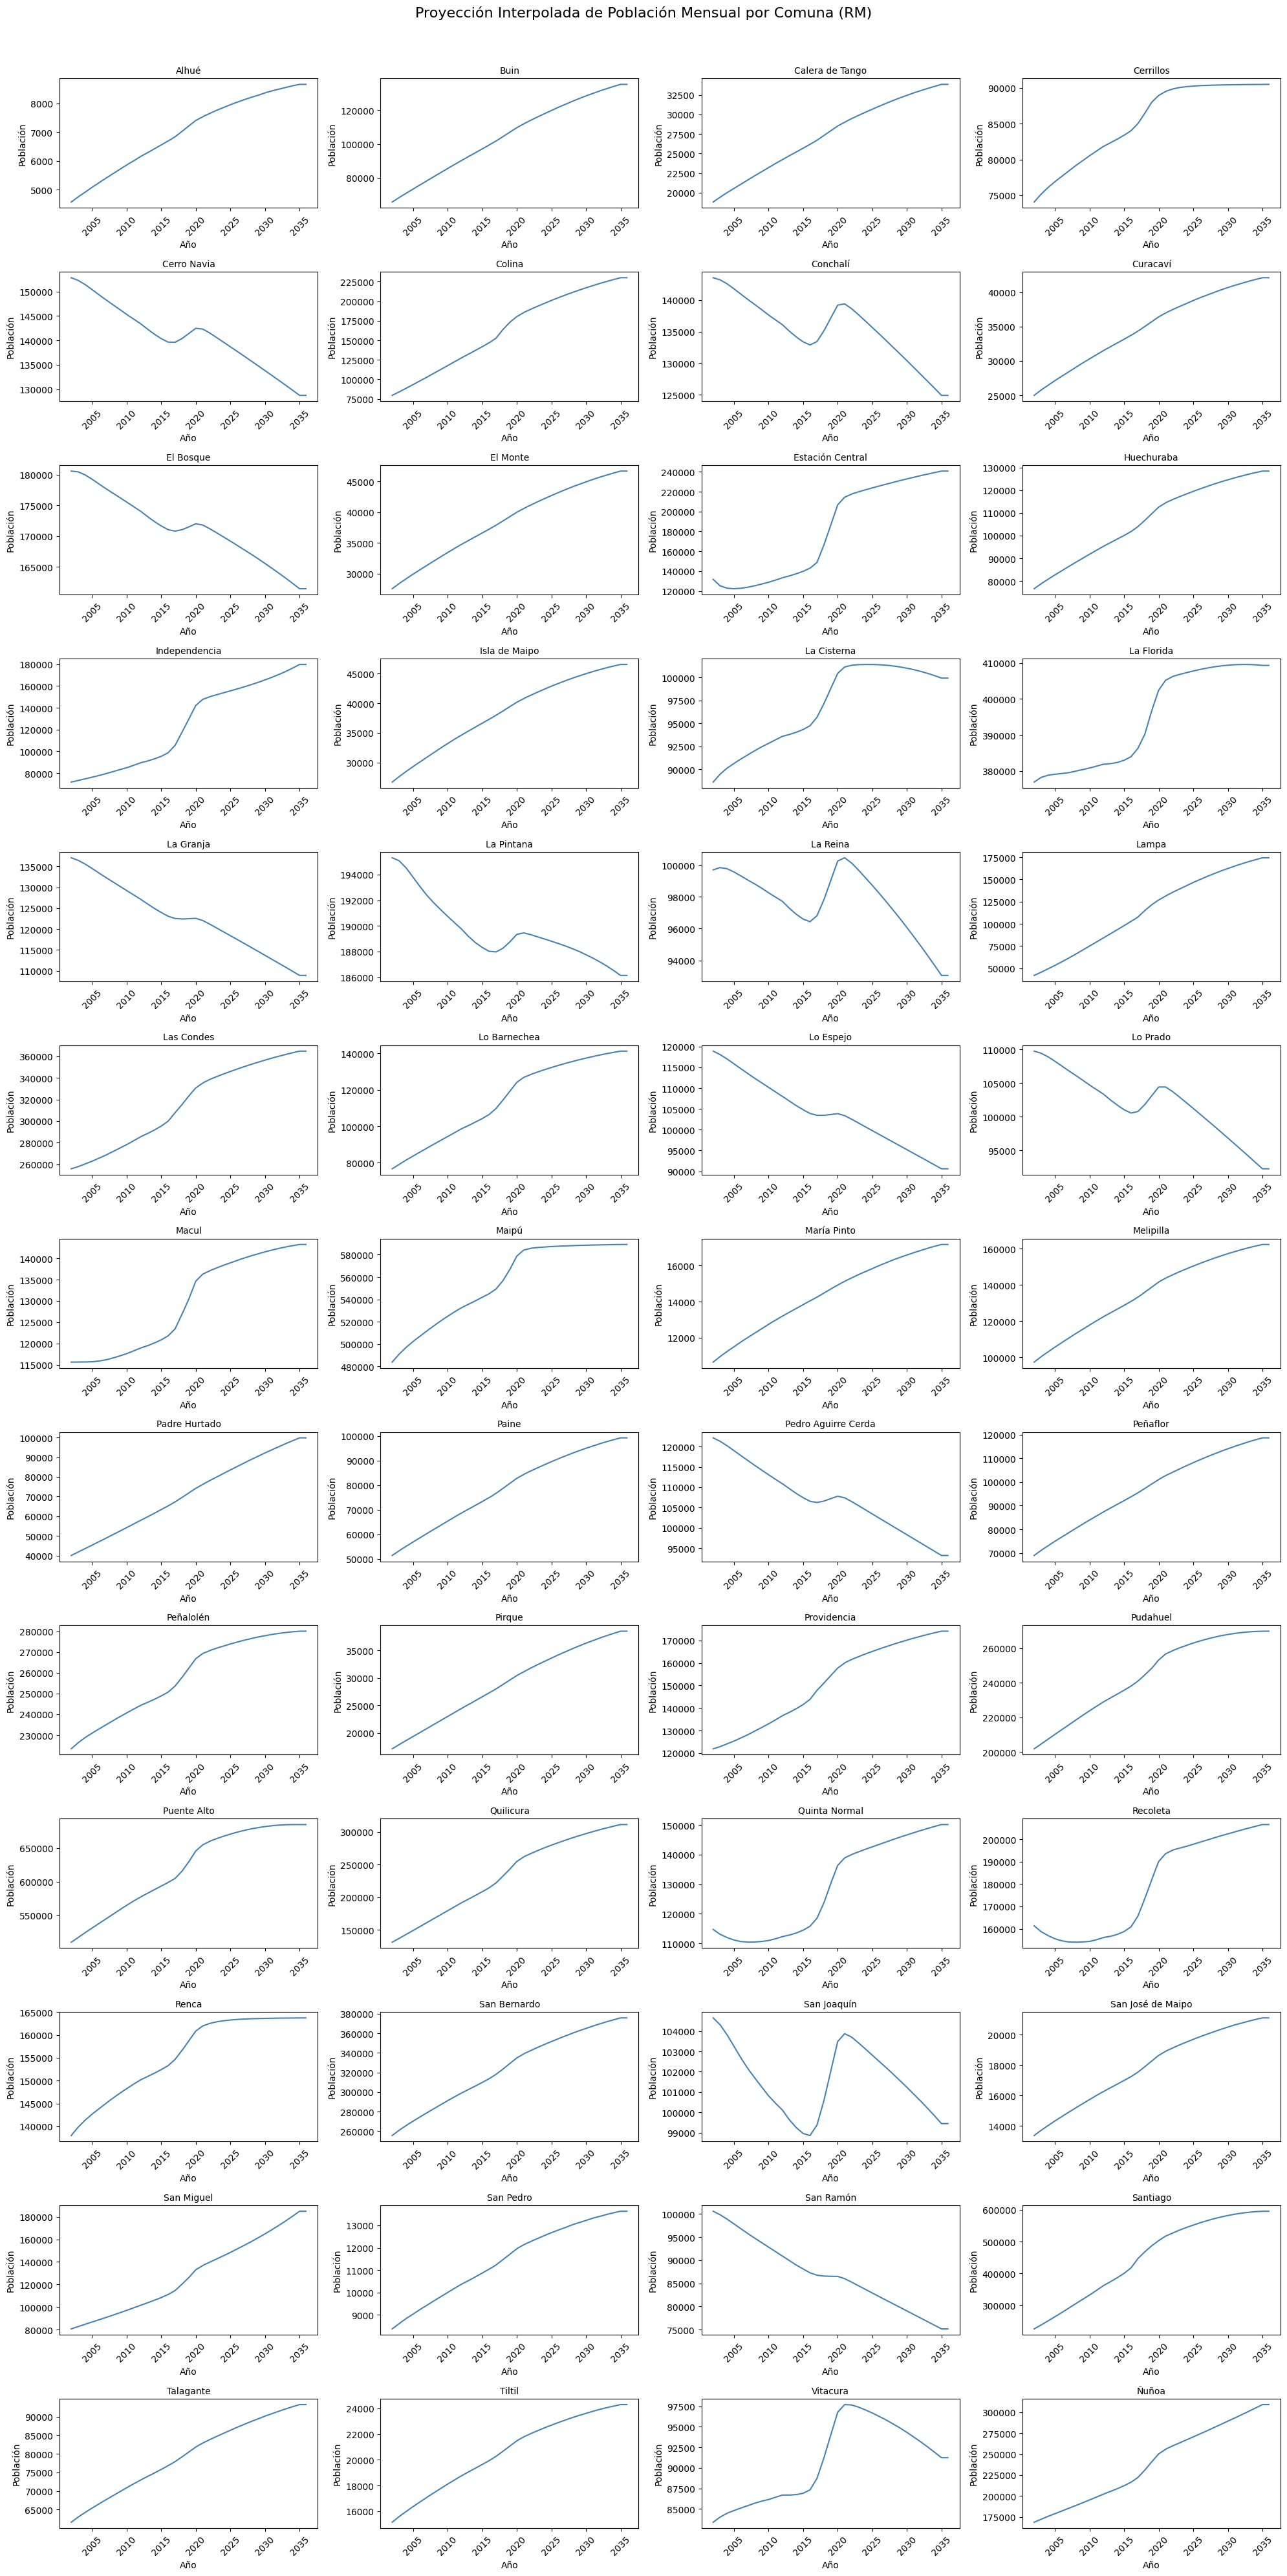

In [19]:
# Lista de comunas ordenadas
comunas = sorted(df_mensual_interp['Nombre Comuna'].unique())

# Parámetros de la grilla
n_comunas = len(comunas)
n_cols = 4
n_rows = (n_comunas + n_cols - 1) // n_cols

# Figura
plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, comuna in enumerate(comunas):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    datos = df_mensual_interp[df_mensual_interp['Nombre Comuna'] == comuna]
    ax.plot(datos['Fecha'], datos['Poblacion'], color='steelblue')
    ax.set_title(comuna, fontsize=10)
    ax.set_xlabel('Año')
    ax.set_ylabel('Población')

    # Mostrar solo cada 5 años
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

# Ajustes finales
plt.tight_layout()
plt.suptitle("Proyección Interpolada de Población Mensual por Comuna (RM)", fontsize=16, y=1.02)
plt.show()

In [34]:
df_mensual_interp.to_csv('poblacion_proyectados_v2.csv', index=False)

In [7]:
df_mensual_interp[(df_mensual_interp['Nombre Comuna'] == 'Paine') & (df_mensual_interp['Mes'] == 12)][['Año', 'Poblacion']]

Año     Poblacion
11843  2002  53187.083333
11855  2003  55003.333333
11867  2004  56746.250000
11879  2005  58460.333333
11891  2006  60175.083333
11903  2007  61886.416667
11915  2008  63586.416667
11927  2009  65258.833333
11939  2010  66911.416667
11951  2011  68545.916667
11963  2012  70098.250000
11975  2013  71631.333333
11987  2014  73189.000000
11999  2015  74768.250000
12011  2016  76512.416667
12023  2017  78484.083333
12035  2018  80539.250000
12047  2019  82594.750000
12059  2020  84244.583333
12071  2021  85644.000000
12083  2022  86950.666667
12095  2023  88212.166667
12107  2024  89440.833333
12119  2025  90630.166667
12131  2026  91762.083333
12143  2027  92860.666667
12155  2028  93914.500000
12167  2029  94913.166667
12179  2030  95861.333333
12191  2031  96766.833333
12203  2032  97623.916667
12215  2033  98422.833333
12227  2034  99170.083333
12239  2035  99232.000000

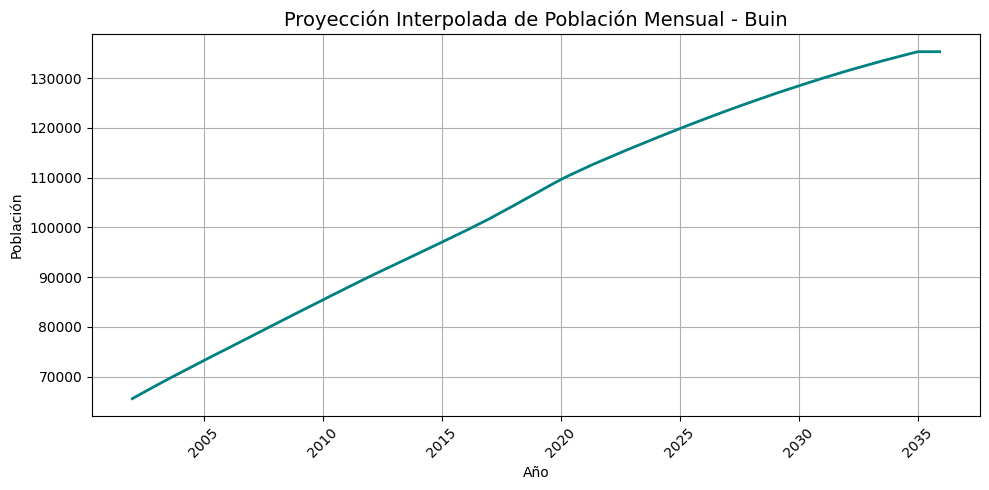

In [8]:
# Filtrar la comuna de Buin
df_buin_ine = df_mensual_interp[df_mensual_interp['Nombre Comuna'] == 'Buin']

# Crear la figura
plt.figure(figsize=(10, 5))
plt.plot(df_buin_ine['Fecha'], df_buin_ine['Poblacion'], color='teal', linewidth=2)

# Títulos y formato
plt.title("Proyección Interpolada de Población Mensual - Buin", fontsize=14)
plt.xlabel("Año")
plt.ylabel("Población")

# Mostrar cada 5 años en el eje x
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.grid(True)
plt.show()

## Histórico clientes y proyección

hacer una proyección por cada combinación comuna-localidad y comparar luego con las proyecciones del INE

In [52]:
df_agua = pd.read_csv('G:\OneDrive - usach.cl\Memoria\Código\Resultados CSV\df_agua.csv')
df_agua["id_combinacion"] = df_agua["Localidad"] + ";" + df_agua["Nombre Corto"] + ";" + df_agua["Tipo Cliente"]
df_agua["Fecha"] = pd.to_datetime(df_agua["Fecha"], format="%Y-%m-%d")

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\IanLagreze\AppData\Local\Temp\ipykernel_13240\1877688799.py:1: SyntaxWarning: invalid escape sequence '\O'
  df_agua = pd.read_csv('G:\OneDrive - usach.cl\Memoria\Código\Resultados CSV\df_agua.csv')


In [50]:
df_agua = df_agua[['Fecha', 'id_combinacion','M3 Ap', 'Clientes']]

In [45]:
# Asegurar que la columna Fecha esté en formato datetime
df_agua['Fecha'] = pd.to_datetime(df_agua['Fecha'], errors='coerce')

# Normalizar 'Grupo Cliente': dejar 'Residencial' y todo lo demás como 'No Residencial'
df_agua['Grupo Cliente'] = df_agua['Tipo Cliente'].apply(lambda x: 'Residencial' if x.upper() == 'RESIDENCIAL' else 'No Residencial')

# Agrupar por combinación única y tipo de cliente
df_agua = df_agua.groupby(['Fecha', 'Nombre Corto', 'Localidad', 'Comuna', 'Grupo Cliente'], as_index=False)[['M3 Ap', 'Clientes']].sum()

# Extraer el año
df_agua['Año'] = df_agua['Fecha'].dt.year

# Agrupar por año, Nombre Corto, Localidad, Comuna y Grupo Cliente
df_anual = df_agua.groupby(['Fecha', 'Nombre Corto', 'Localidad', 'Comuna', 'Grupo Cliente'], as_index=False )[['M3 Ap', 'Clientes']].sum()


In [23]:
# Paso 1: Separar residencial y no residencial
residencial = df_anual_2024[df_anual_2024['Grupo Cliente'] == 'Residencial']
no_residencial = df_anual_2024[df_anual_2024['Grupo Cliente'] != 'Residencial']

# Paso 2: Renombrar columnas para merge posterior
residencial = residencial.rename(columns={'M3 Ap': 'M3_Res'})
no_residencial = no_residencial.rename(columns={'M3 Ap': 'M3_NoRes'})

# Paso 3: Unir por Nombre Corto + Localidad + Comuna
df_proporcion = pd.merge(
    residencial[['Nombre Corto', 'Localidad', 'Comuna', 'M3_Res']],
    no_residencial[['Nombre Corto', 'Localidad', 'Comuna', 'M3_NoRes']],
    on=['Nombre Corto', 'Localidad', 'Comuna'],
    how='outer'
).fillna(0)

# Paso 4: Calcular proporción no residencial
df_proporcion['Proporcion_NoRes'] = df_proporcion['M3_NoRes'] / (df_proporcion['M3_Res'] + df_proporcion['M3_NoRes'])

# Paso 5: Aplicar regla de decisión
# Por defecto: no_desagregar = 1 si proporción < 20%
df_proporcion['no_desagregar'] = (df_proporcion['Proporcion_NoRes'] < 0.2).astype(int)

# Paso 6 (opcional): marcar casos justificados manualmente
# Por ejemplo, si quieres forzar el uso agregado en ciertos casos:
casos_justificados = [
    # ('Nombre Corto', 'Localidad', 'Comuna'),
    # ('AGUAS ANDINAS', 'BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL', 'BUIN'),
]
df_proporcion.loc[
    df_proporcion.set_index(['Nombre Corto', 'Localidad', 'Comuna']).index.isin(casos_justificados),
    'no_desagregar'
] = 1

In [ ]:
# Paso 1: Crear una copia para trabajar con seguridad
df_agua_mod = df_agua.copy()

# Paso 2: Identificar combinaciones con no_desagregar == 1
combinaciones_agregadas = df_proporcion[df_proporcion['no_desagregar'] == 1][
    ['Nombre Corto', 'Localidad', 'Comuna']
]

# Paso 3: Marcar en df_agua las filas que deben agregarse
df_agua_mod['Agrupar'] = df_agua_mod.merge(
    combinaciones_agregadas.assign(Agrupar=True),
    on=['Nombre Corto', 'Localidad', 'Comuna'],
    how='left'
)['Agrupar'].fillna(False)

# Paso 4: Reemplazar "Grupo Cliente" por "Total" donde corresponde
df_agua_mod.loc[df_agua_mod['Agrupar'], 'Grupo Cliente'] = 'Total'

# Paso 5: Agrupar sumando M3 Ap y Clientes
df_agua_final = df_agua_mod.groupby(
    ['Fecha', 'Nombre Corto', 'Localidad', 'Comuna', 'Tipo Cliente'],
    as_index=False
)[['M3 Ap', 'Clientes']].sum()

C:\Users\IanLagreze\AppData\Local\Temp\ipykernel_13240\2545069295.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  )['Agrupar'].fillna(False)


In [25]:
df_agua_final.loc[df_agua_final["Grupo Cliente"] == "Total", "Grupo Cliente"] = "Residencial"

In [26]:
df_agua_final.head()


Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
2 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
3 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
4 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   

            Comuna   Grupo Cliente      M3 Ap  Clientes  
0             BUIN  No Residencial  149980.55    1110.0  
1             BUIN     Residencial  406371.24   16337.0  
2            PAINE  No Residencial   57303.35     484.0  
3            PAINE     Residencial  169485.26    8446.0  
4  CALERA DE TANGO  No Residencial   51454.45     268.0

In [57]:
# Fechas objetivo
fechas_futuras = pd.date_range(start='2025-01-01', end='2030-12-01', freq='MS')
n_periods = len(fechas_futuras)

# Función para elegir el mejor modelo
def forecast_best_model(serie, n_periods):
    serie = serie.dropna()
    if len(serie) < 2:
        return np.full(n_periods, np.nan)

    preds = {}

    # Regresión lineal
    try:
        X = np.arange(len(serie)).reshape(-1, 1)
        y = serie.values
        model = LinearRegression().fit(X, y)
        X_pred = np.arange(len(serie), len(serie) + n_periods).reshape(-1, 1)
        preds['regresion'] = model.predict(X_pred)
    except:
        preds['regresion'] = np.full(n_periods, np.nan)

    # Interpolación lineal extendida
    try:
        last_value = serie.iloc[-1]
        slope = (serie.iloc[-1] - serie.iloc[0]) / (len(serie) - 1) if len(serie) > 1 else 0
        preds['interpolacion'] = last_value + slope * np.arange(1, n_periods + 1)
    except:
        preds['interpolacion'] = np.full(n_periods, np.nan)

    # ARIMA
    try:
        arima_model = ARIMA(serie, order=(1, 1, 1)).fit()
        preds['arima'] = arima_model.forecast(steps=n_periods).values
    except:
        preds['arima'] = np.full(n_periods, np.nan)

    # Evaluación con RMSE si hay suficientes datos
    if len(serie) >= 12:
        test = serie[-12:]
        train = serie[:-12]
        rmse_scores = {}
        for key in preds:
            pred = preds[key][:12]
            if not np.isnan(pred).all():
                rmse = mean_squared_error(test, pred, squared=False)
            else:
                rmse = np.inf
            rmse_scores[key] = rmse
        best_model = min(rmse_scores, key=rmse_scores.get)
    else:
        best_model = 'regresion' if not np.isnan(preds['regresion']).all() else 'interpolacion'

    return preds[best_model]

# Crear lista para almacenar resultados
proyecciones = []

# Agrupar por combinación única
grupos = df_agua.groupby(['id_combinacion'])

for (id), grupo_df in grupos:
    grupo_df = grupo_df.sort_values('Fecha')
    
    # Series históricas
    clientes_hist = grupo_df.set_index('Fecha')['Clientes']
    m3_hist = grupo_df.set_index('Fecha')['M3 Ap']

    # Proyecciones
    clientes_pred = forecast_best_model(clientes_hist, n_periods)
    m3_pred = forecast_best_model(m3_hist, n_periods)

    # Armar DataFrame con mismo formato
    df_pred = pd.DataFrame({
        'Fecha': fechas_futuras,
        'id_combinacion': [id[0]] * n_periods,
        'Clientes': clientes_pred,
        'M3 Ap': m3_pred
    })

    proyecciones.append(df_pred)

# Concatenar resultados
df_proyecciones = pd.concat(proyecciones, ignore_index=True)



C:\Users\IanLagreze\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\IanLagreze\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\IanLagreze\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\IanLagreze\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\IanLagreze\App

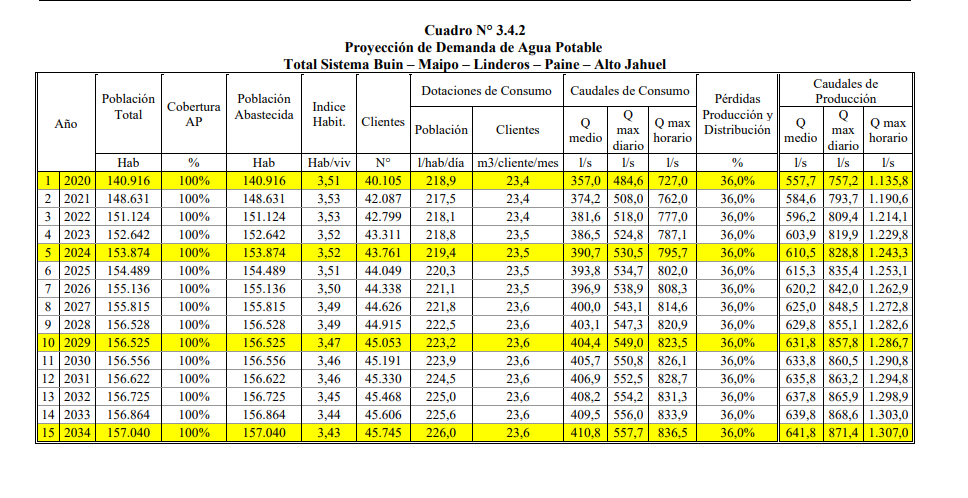

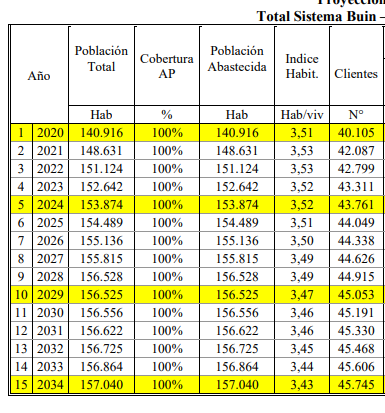

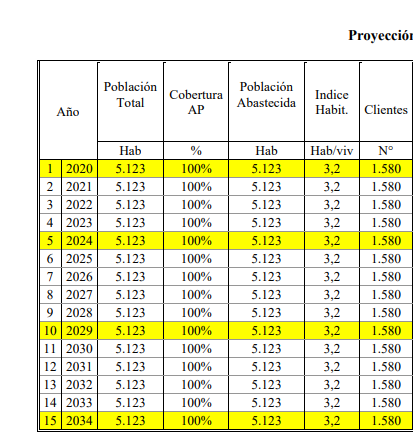

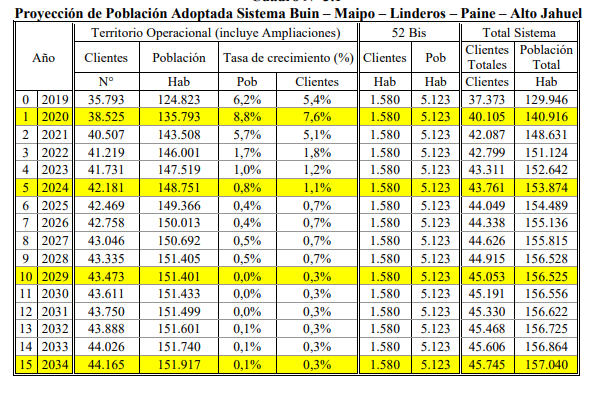

In [58]:
df_proyecciones

Fecha                                    id_combinacion  \
0     2025-01-01               AGUAS COLINA;AGUAS COLINA;Comercial   
1     2025-02-01               AGUAS COLINA;AGUAS COLINA;Comercial   
2     2025-03-01               AGUAS COLINA;AGUAS COLINA;Comercial   
3     2025-04-01               AGUAS COLINA;AGUAS COLINA;Comercial   
4     2025-05-01               AGUAS COLINA;AGUAS COLINA;Comercial   
...          ...                                               ...   
17347 2030-08-01  VILLA LOS DOMINICOS;AGUAS CORDILLERA;Residencial   
17348 2030-09-01  VILLA LOS DOMINICOS;AGUAS CORDILLERA;Residencial   
17349 2030-10-01  VILLA LOS DOMINICOS;AGUAS CORDILLERA;Residencial   
17350 2030-11-01  VILLA LOS DOMINICOS;AGUAS CORDILLERA;Residencial   
17351 2030-12-01  VILLA LOS DOMINICOS;AGUAS CORDILLERA;Residencial   

          Clientes         M3 Ap  
0        22.000000   3863.003355  
1        22.000000   3853.336710  
2        22.000000   3843.670065  
3        22.000000   3834.003419  
4        22.000000   3824.336774  
...            ...           ...  
17347  2028.703991  83803.984574  
17348  2015.622103  82340.008261  
17349  2002.540216  80876.031948  
17350  1989.458328  79412.055635  
17351  1976.376441  77948.079322  

[17352 rows x 4 columns]

In [59]:
df_proyecciones.to_csv('clientes_proyectados.csv', index=False)

In [18]:
df_proyecciones[
    (df_proyecciones['Nombre Corto'] == 'AGUAS ANDINAS') &
    (df_proyecciones['Localidad'] == 'BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL') &
    (df_proyecciones['Fecha'].dt.month == 1)
].groupby('Fecha', as_index=False)['Clientes'].sum()

Fecha      Clientes
0 2025-01-01  41903.211405
1 2026-01-01  42086.991537
2 2027-01-01  42185.694003
3 2028-01-01  42241.113778
4 2029-01-01  42274.442999
5 2030-01-01  42296.497474

In [19]:
df_agua_final[
    (df_agua_final['Nombre Corto'] == 'AGUAS ANDINAS') &
    (df_agua_final['Localidad'] == 'BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL') &
    (df_agua_final['Fecha'].dt.month == 1)
].groupby('Fecha', as_index=False)['Clientes'].sum()

Fecha  Clientes
0  2012-01-01   26377.0
1  2013-01-01   27178.0
2  2014-01-01   28245.0
3  2015-01-01   28640.0
4  2016-01-01   29043.0
5  2017-01-01   31252.0
6  2018-01-01   32900.0
7  2019-01-01   34278.0
8  2020-01-01   36523.0
9  2021-01-01   37793.0
10 2022-01-01   38603.0
11 2023-01-01   40634.0
12 2024-01-01   41719.0

In [20]:
df_agua_final.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
2 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
3 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
4 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   

            Comuna   Grupo Cliente      M3 Ap  Clientes  
0             BUIN  No Residencial  149980.55    1110.0  
1             BUIN     Residencial  406371.24   16337.0  
2            PAINE  No Residencial   57303.35     484.0  
3            PAINE     Residencial  169485.26    8446.0  
4  CALERA DE TANGO  No Residencial   51454.45     268.0

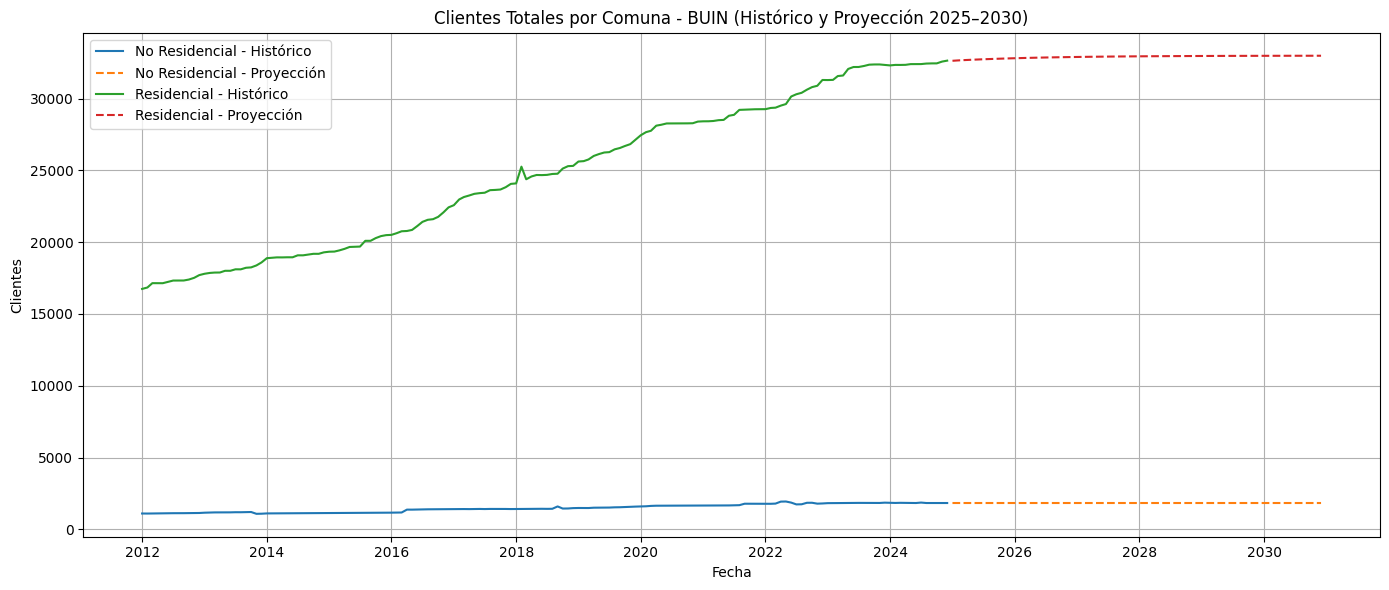

In [21]:
# Paso 1: Agrupar histórico y proyección por Fecha, Comuna, Grupo Cliente
hist_buin = (
    df_agua_final
    .groupby(['Fecha', 'Comuna', 'Grupo Cliente'], as_index=False)[['Clientes', 'M3 Ap']]
    .sum()
)

proj_buin = (
    df_proyecciones
    .groupby(['Fecha', 'Comuna', 'Grupo Cliente'], as_index=False)[['Clientes', 'M3 Ap']]
    .sum()
)

# Paso 2: Filtrar solo BUIN
hist_buin = hist_buin[hist_buin['Comuna'] == 'BUIN'].copy()
proj_buin = proj_buin[proj_buin['Comuna'] == 'BUIN'].copy()

# Paso 3: Marcar origen y concatenar
hist_buin['Origen'] = 'Histórico'
proj_buin['Origen'] = 'Proyección'
df_buin = pd.concat([hist_buin, proj_buin], ignore_index=True)

# Paso 4: Graficar por tipo de cliente
plt.figure(figsize=(14, 6))
for tipo in df_buin['Grupo Cliente'].unique():
    df_tipo = df_buin[df_buin['Grupo Cliente'] == tipo]
    df_hist = df_tipo[df_tipo['Origen'] == 'Histórico']
    df_proj = df_tipo[df_tipo['Origen'] == 'Proyección']

    plt.plot(df_hist['Fecha'], df_hist['Clientes'], label=f'{tipo} - Histórico', linestyle='-')
    plt.plot(df_proj['Fecha'], df_proj['Clientes'], label=f'{tipo} - Proyección', linestyle='--')

plt.title('Clientes Totales por Comuna - BUIN (Histórico y Proyección 2025–2030)')
plt.xlabel('Fecha')
plt.ylabel('Clientes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
df_buin.head()

Fecha Comuna   Grupo Cliente  Clientes      M3 Ap     Origen
0 2012-01-01   BUIN  No Residencial    1110.0  149980.55  Histórico
1 2012-01-01   BUIN     Residencial   16746.0  419526.24  Histórico
2 2012-02-01   BUIN  No Residencial    1107.0  132158.80  Histórico
3 2012-02-01   BUIN     Residencial   16844.0  397879.47  Histórico
4 2012-03-01   BUIN  No Residencial    1112.0  144611.71  Histórico

In [23]:
# Paso 1: Usar el DataFrame combinado de antes
df_buin_total = df_buin.copy()

# Paso 2: Agrupar por Fecha y Origen, sumando todos los tipos de cliente
df_buin_total_agrupado = (
    df_buin_total
    .groupby(['Fecha', 'Origen'], as_index=False)['Clientes']
    .sum()
)

In [24]:
df_buin_total[df_buin_total['Fecha'].dt.month == 1].groupby('Fecha', as_index=False)['Clientes'].sum()

Fecha      Clientes
0  2012-01-01  17856.000000
1  2013-01-01  18967.000000
2  2014-01-01  20002.000000
3  2015-01-01  20476.000000
4  2016-01-01  21678.000000
5  2017-01-01  23993.000000
6  2018-01-01  25516.000000
7  2019-01-01  27109.000000
8  2020-01-01  29041.000000
9  2021-01-01  30071.000000
10 2022-01-01  31048.000000
11 2023-01-01  33118.000000
12 2024-01-01  34161.000000
13 2025-01-01  34469.500028
14 2026-01-01  34647.202917
15 2027-01-01  34735.599856
16 2028-01-01  34780.714937
17 2029-01-01  34803.740292
18 2030-01-01  34815.491727

In [25]:
df_buin_total[df_buin_total['Fecha'].dt.month == 12].groupby('Fecha', as_index=False)['Clientes'].sum()


Fecha      Clientes
0  2012-12-01  18854.000000
1  2013-12-01  19687.000000
2  2014-12-01  20429.000000
3  2015-12-01  21653.000000
4  2016-12-01  23845.000000
5  2017-12-01  25479.000000
6  2018-12-01  26796.000000
7  2019-12-01  28718.000000
8  2020-12-01  30051.000000
9  2021-12-01  31048.000000
10 2022-12-01  33102.000000
11 2023-12-01  34208.000000
12 2024-12-01  34479.000000
13 2025-12-01  34636.794415
14 2026-12-01  34730.287692
15 2027-12-01  34778.003774
16 2028-12-01  34802.356598
17 2029-12-01  34814.785533
18 2030-12-01  34821.128879

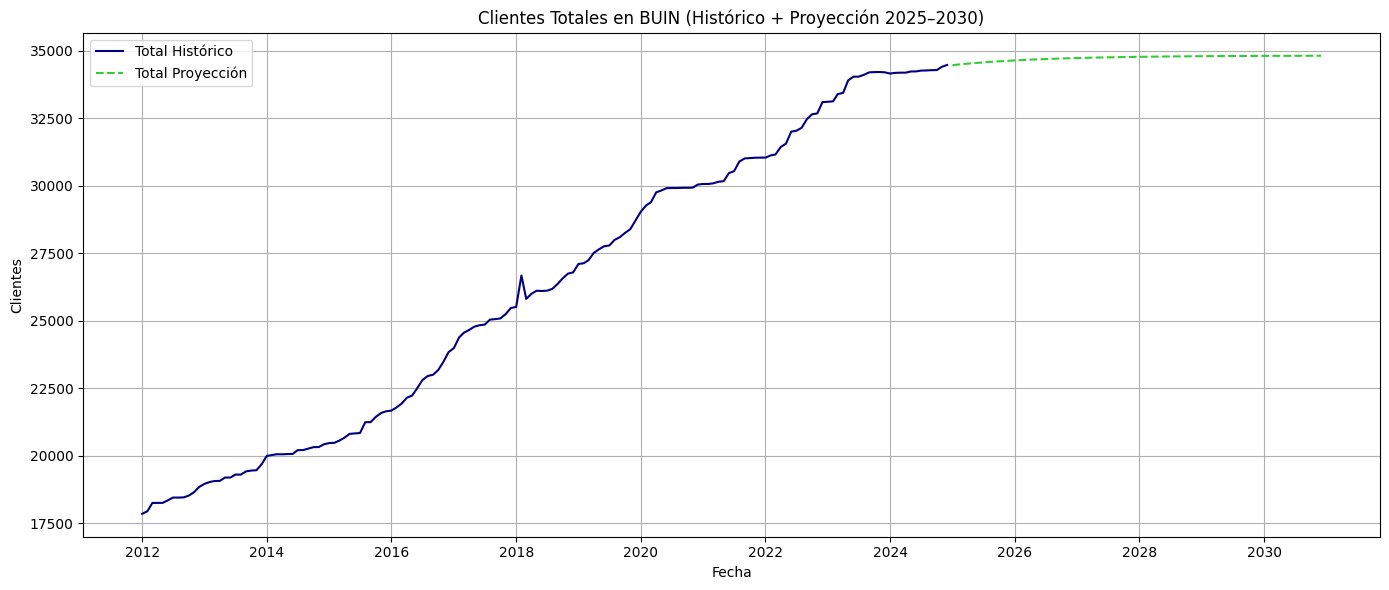

In [26]:
# Paso 3: Separar histórico y proyección
df_hist = df_buin_total_agrupado[df_buin_total_agrupado['Origen'] == 'Histórico']
df_proj = df_buin_total_agrupado[df_buin_total_agrupado['Origen'] == 'Proyección']

# Paso 4: Graficar
plt.figure(figsize=(14, 6))
plt.plot(df_hist['Fecha'], df_hist['Clientes'], label='Total Histórico', color='navy')
plt.plot(df_proj['Fecha'], df_proj['Clientes'], label='Total Proyección', color='limegreen', linestyle='--')

plt.title('Clientes Totales en BUIN (Histórico + Proyección 2025–2030)')
plt.xlabel('Fecha')
plt.ylabel('Clientes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


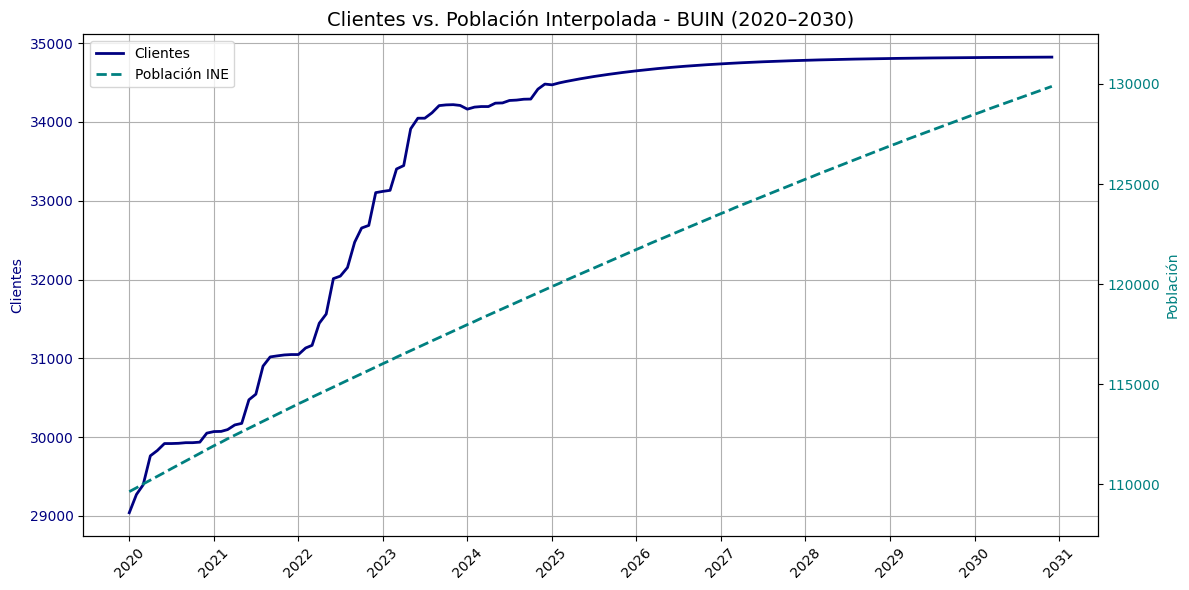

In [27]:
# Asegurar que las fechas estén en datetime
df_buin_ine['Fecha'] = pd.to_datetime(df_buin_ine['Fecha'])
df_buin_total['Fecha'] = pd.to_datetime(df_buin_total['Fecha'])

# Paso 1: Agrupar clientes por fecha (sumando todos los tipos de cliente)
clientes_totales = (
    df_buin_total
    .groupby('Fecha', as_index=False)['Clientes']
    .sum()
)

# Paso 2: Filtrar ambas series entre 2020 y 2030
clientes_filtrado = clientes_totales[
    (clientes_totales['Fecha'] >= '2020-01-01') & (clientes_totales['Fecha'] <= '2030-12-31')
]

poblacion_filtrada = df_buin_ine[
    (df_buin_ine['Fecha'] >= '2020-01-01') & (df_buin_ine['Fecha'] <= '2030-12-31')
]

# Paso 3: Crear figura y eje primario
fig, ax1 = plt.subplots(figsize=(12, 6))

# Curva de clientes (eje izquierdo)
ax1.plot(clientes_filtrado['Fecha'], clientes_filtrado['Clientes'], color='navy', linewidth=2, label='Clientes')
ax1.set_ylabel('Clientes', color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# Eje x: formato de fechas
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Paso 4: Crear eje secundario para población
ax2 = ax1.twinx()
ax2.plot(poblacion_filtrada['Fecha'], poblacion_filtrada['Poblacion'], color='teal', linewidth=2, linestyle='--', label='Población INE')
ax2.set_ylabel('Población', color='teal')
ax2.tick_params(axis='y', labelcolor='teal')

# Ajustar límites del eje Y de población si son válidos
pob_min = poblacion_filtrada['Poblacion'].min()
pob_max = poblacion_filtrada['Poblacion'].max()
if np.isfinite(pob_min) and np.isfinite(pob_max):
    ax2.set_ylim(pob_min * 0.98, pob_max * 1.02)

# Título y leyenda
plt.title("Clientes vs. Población Interpolada - BUIN (2020–2030)", fontsize=14)
fig.tight_layout()
ax1.grid(True)

# Combinar leyendas
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()



In [28]:
import unicodedata

# Función para quitar tildes y pasar a mayúsculas
def normalizar_comuna(nombre):
    nombre = unicodedata.normalize('NFKD', nombre).encode('ASCII', 'ignore').decode('utf-8')
    return nombre.upper()

# Aplicar transformación
df_mensual_interp['Nombre Comuna'] = df_mensual_interp['Nombre Comuna'].apply(normalizar_comuna)

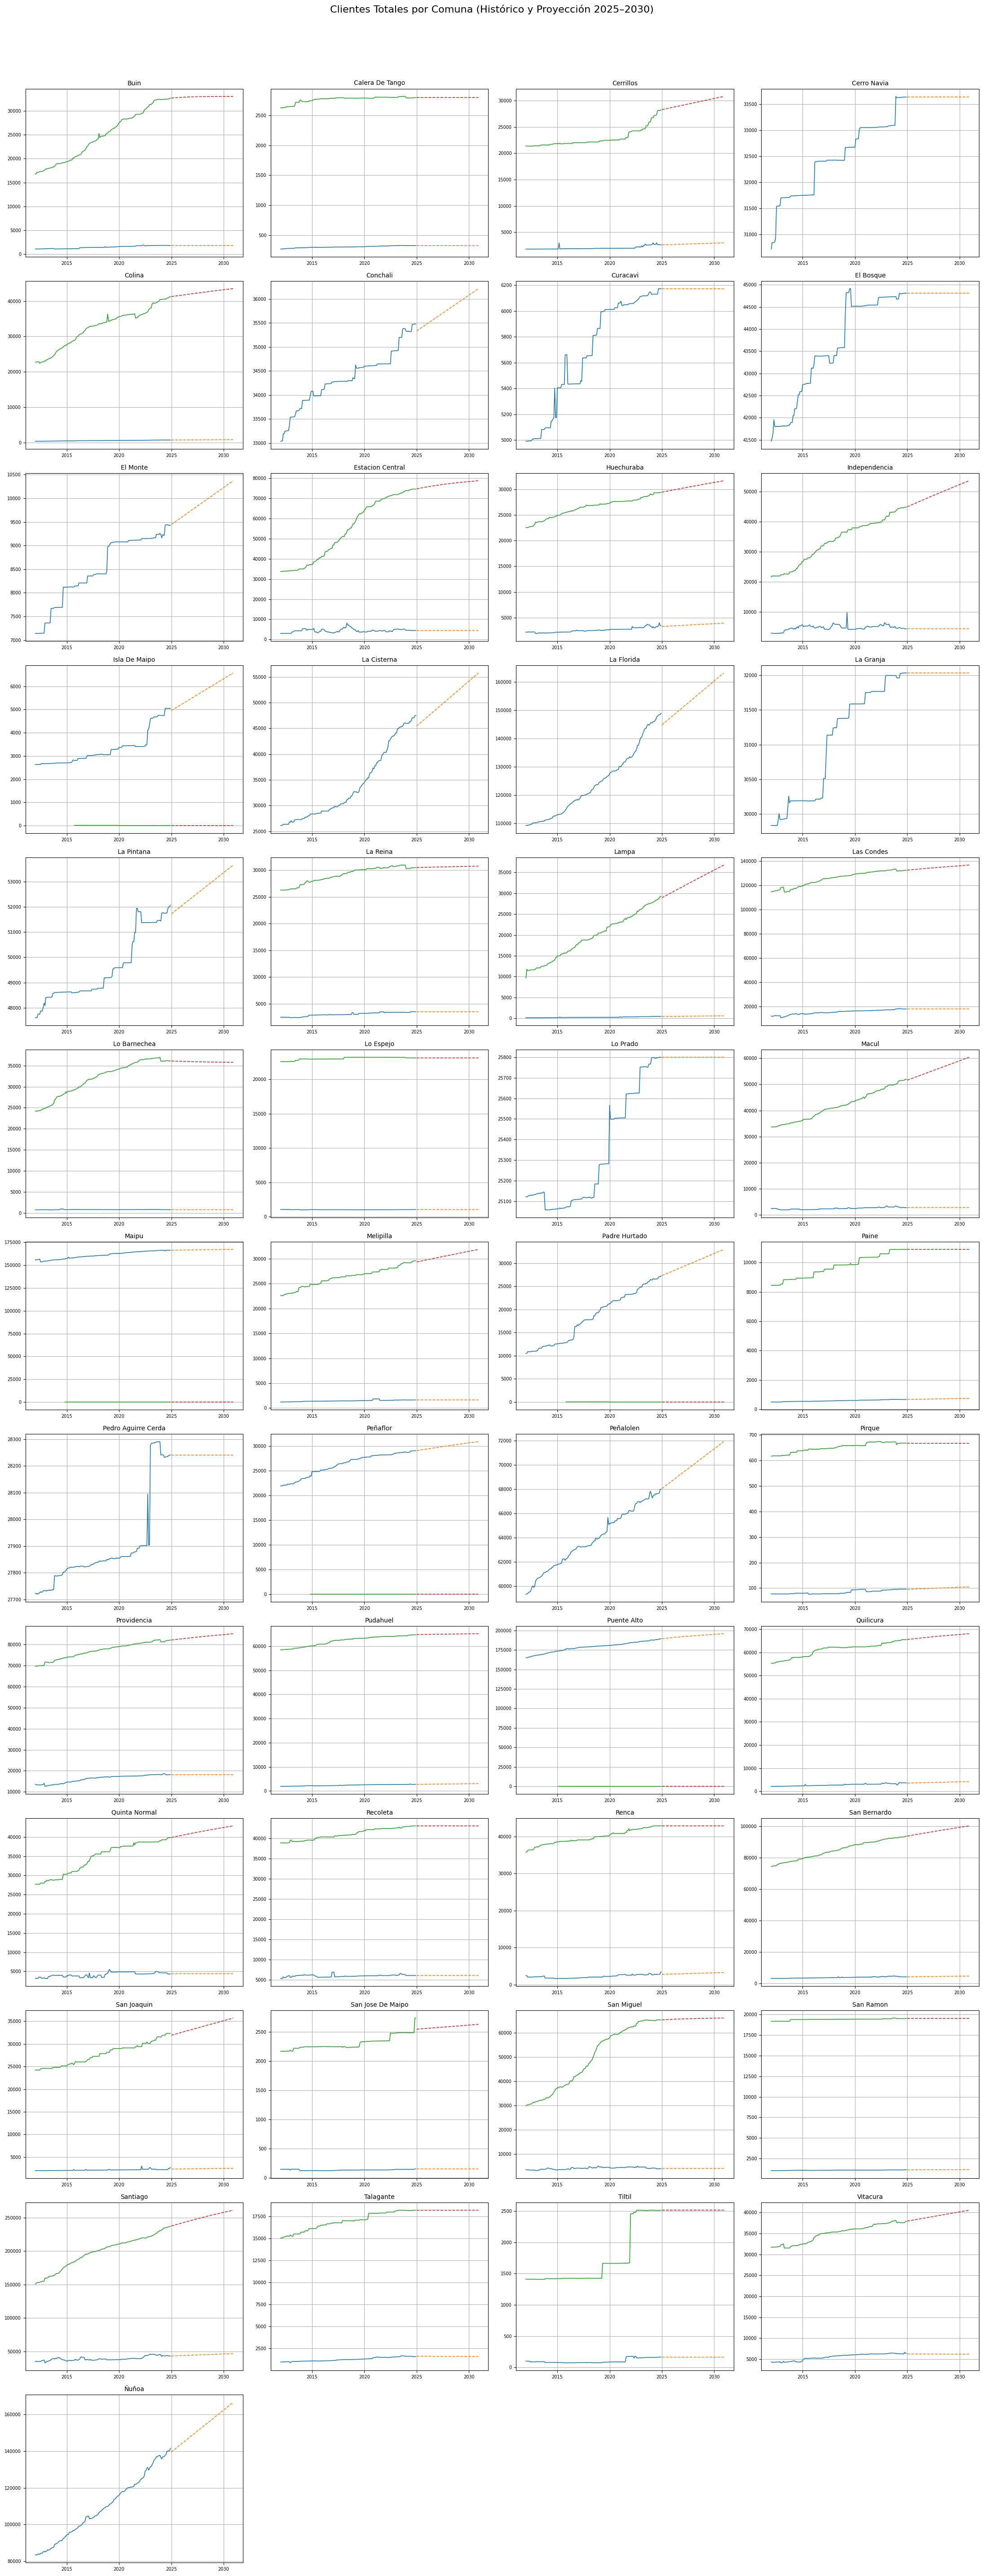

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Paso 1: Agrupar histórico y proyección por Fecha, Comuna, Grupo Cliente
hist_all = (
    df_agua_final
    .groupby(['Fecha', 'Comuna', 'Grupo Cliente'], as_index=False)[['Clientes', 'M3 Ap']]
    .sum()
)

proj_all = (
    df_proyecciones
    .groupby(['Fecha', 'Comuna', 'Grupo Cliente'], as_index=False)[['Clientes', 'M3 Ap']]
    .sum()
)

# Paso 2: Marcar origen
hist_all['Origen'] = 'Histórico'
proj_all['Origen'] = 'Proyección'

# Paso 3: Concatenar ambos
df_completo = pd.concat([hist_all, proj_all], ignore_index=True)

# Paso 4: Obtener comunas únicas
comunas = sorted(df_completo['Comuna'].unique())
n = len(comunas)
cols = 4
rows = int(np.ceil(n / cols))

# Paso 5: Crear figura con subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5), sharex=False)
axes = axes.flatten()

# Paso 6: Graficar por comuna
for i, comuna in enumerate(comunas):
    ax = axes[i]
    df_comuna = df_completo[df_completo['Comuna'] == comuna]

    for tipo in df_comuna['Grupo Cliente'].unique():
        df_tipo = df_comuna[df_comuna['Grupo Cliente'] == tipo]
        df_hist = df_tipo[df_tipo['Origen'] == 'Histórico']
        df_proj = df_tipo[df_tipo['Origen'] == 'Proyección']

        ax.plot(df_hist['Fecha'], df_hist['Clientes'], label=f'{tipo} - Hist.', linestyle='-', linewidth=1.2)
        ax.plot(df_proj['Fecha'], df_proj['Clientes'], label=f'{tipo} - Proy.', linestyle='--', linewidth=1.2)

    ax.set_title(comuna.title(), fontsize=10)
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True)

# Paso 7: Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Paso 8: Ajustes finales
plt.suptitle("Clientes Totales por Comuna (Histórico y Proyección 2025–2030)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


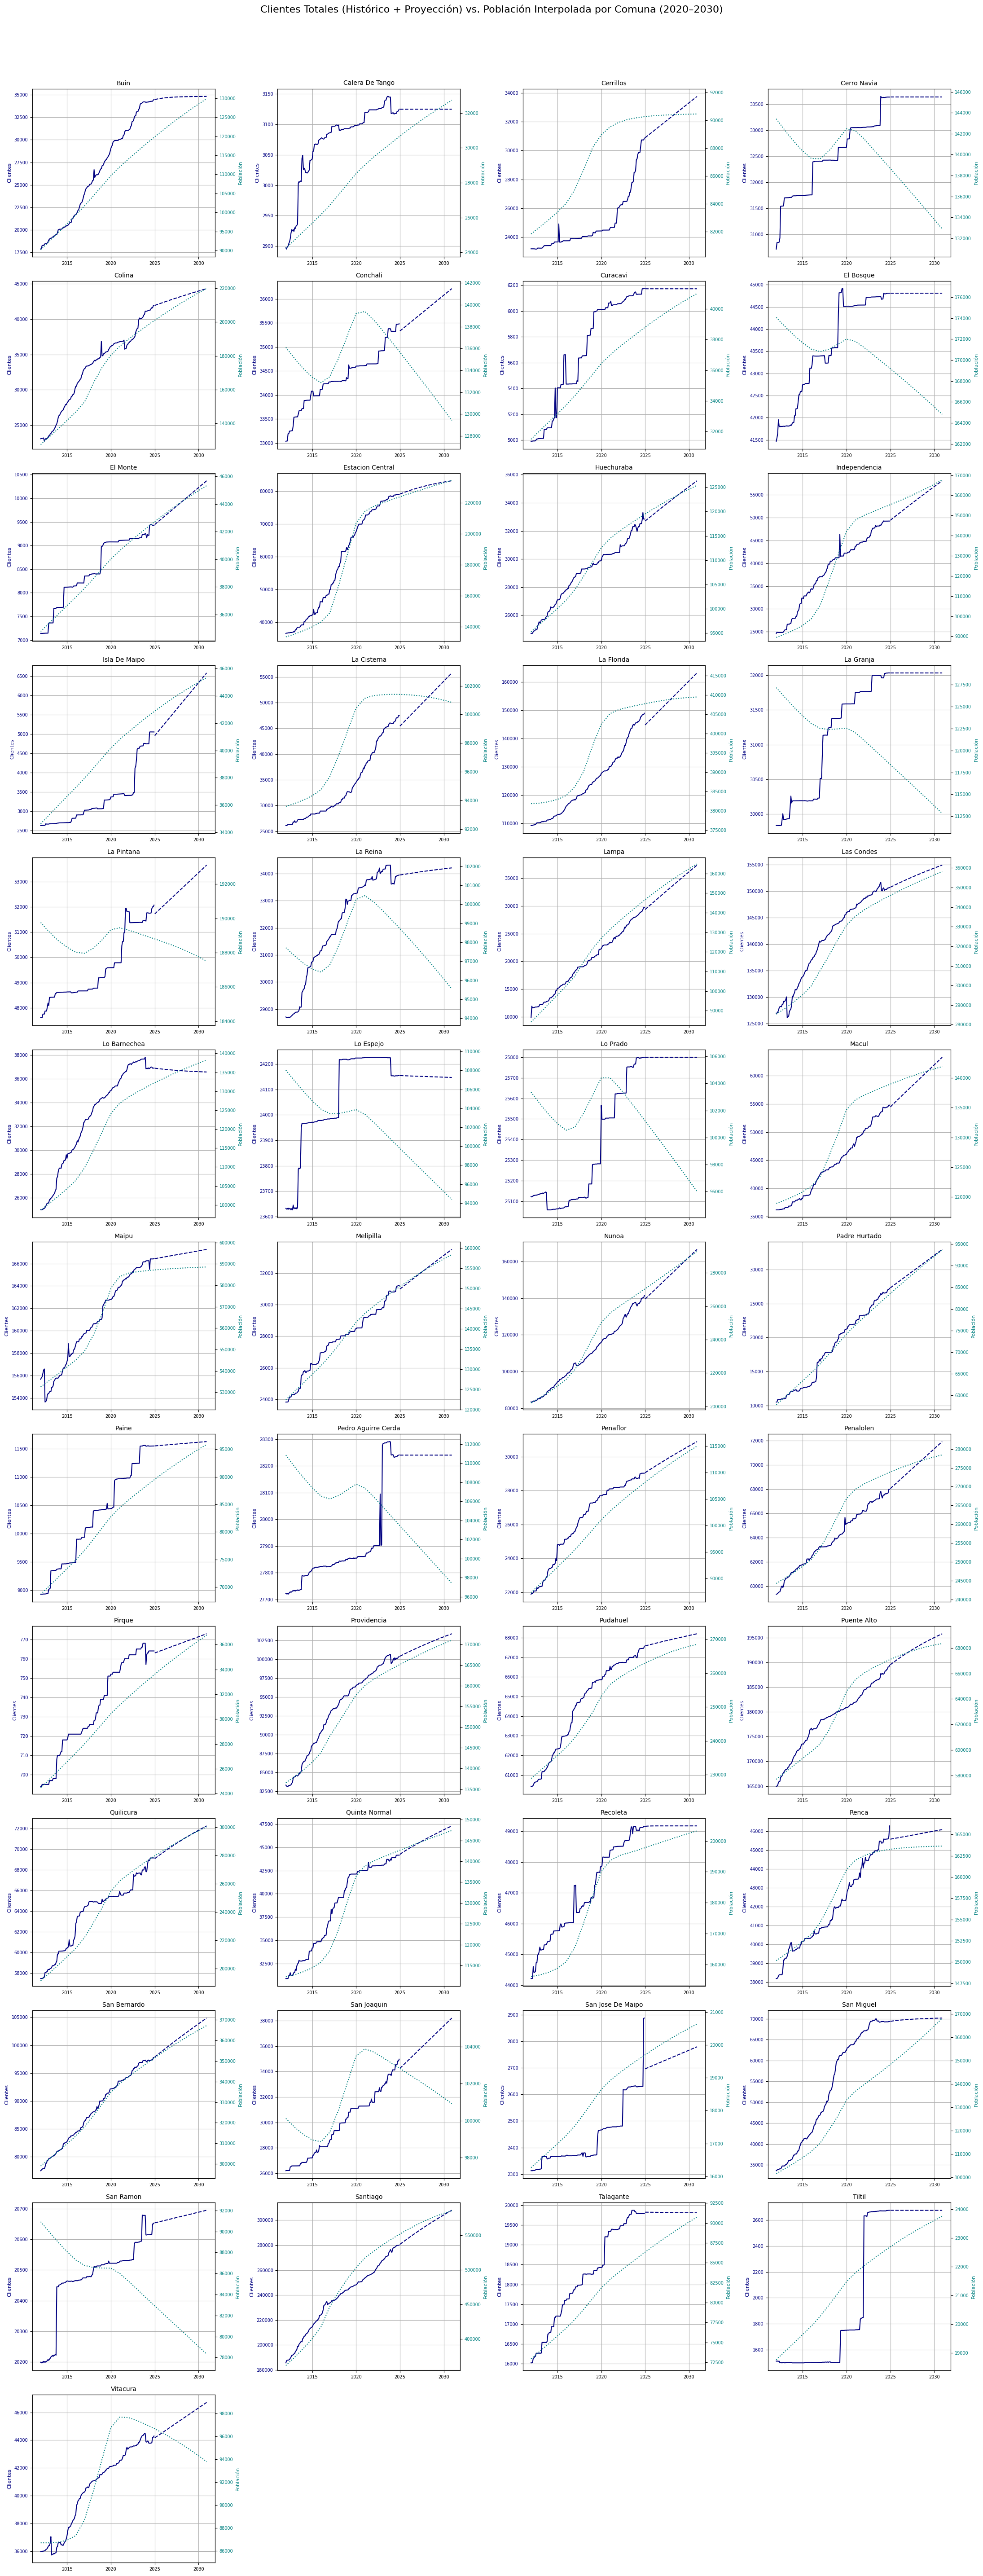

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import unicodedata

# Asegurar fechas en datetime
df_completo['Fecha'] = pd.to_datetime(df_completo['Fecha'])
df_mensual_interp['Fecha'] = pd.to_datetime(df_mensual_interp['Fecha'])

# Normalizar nombres de comuna
def normalizar_comuna(nombre):
    return unicodedata.normalize('NFKD', nombre).encode('ASCII', 'ignore').decode('utf-8').upper()

df_completo['Comuna'] = df_completo['Comuna'].apply(normalizar_comuna)
df_mensual_interp['Nombre Comuna'] = df_mensual_interp['Nombre Comuna'].apply(normalizar_comuna)

# Agrupar clientes por Fecha, Comuna y Origen (sumando todos los tipos de cliente)
df_clientes_total = (
    df_completo
    .groupby(['Fecha', 'Comuna', 'Origen'], as_index=False)['Clientes']
    .sum()
)

# Comunas en común
comunas = sorted(set(df_clientes_total['Comuna']).intersection(df_mensual_interp['Nombre Comuna']))

# Configurar cuadrícula
n = len(comunas)
cols = 4
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5), sharex=False)
axes = axes.flatten()

for i, comuna in enumerate(comunas):
    ax1 = axes[i]

    # Filtrar clientes y población
    df_cli = df_clientes_total[df_clientes_total['Comuna'] == comuna]
    df_pob = df_mensual_interp[
        (df_mensual_interp['Nombre Comuna'] == comuna) &
        (df_mensual_interp['Fecha'] >= '2012-01-01') &
        (df_mensual_interp['Fecha'] <= '2030-12-31')
    ]

    if df_cli.empty or df_pob.empty:
        ax1.set_visible(False)
        continue

    # Separar histórico y proyección
    df_hist = df_cli[(df_cli['Origen'] == 'Histórico') & (df_cli['Fecha'] >= '2012-01-01')]
    df_proj = df_cli[(df_cli['Origen'] == 'Proyección') & (df_cli['Fecha'] <= '2030-12-31')]

    # Clientes (eje izquierdo)
    ax1.plot(df_hist['Fecha'], df_hist['Clientes'], label='Histórico', linestyle='-', color='navy', linewidth=1.5)
    ax1.plot(df_proj['Fecha'], df_proj['Clientes'], label='Proyección', linestyle='--', color='navy', linewidth=1.5)
    ax1.set_ylabel('Clientes', color='navy', fontsize=8)
    ax1.tick_params(axis='y', labelcolor='navy', labelsize=7)
    ax1.tick_params(axis='x', labelsize=7)
    ax1.xaxis.set_major_locator(mdates.YearLocator(5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Población (eje derecho)
    ax2 = ax1.twinx()
    ax2.plot(df_pob['Fecha'], df_pob['Poblacion'], color='teal', linewidth=1.5, linestyle=':', label='Población')
    ax2.set_ylabel('Población', color='teal', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='teal', labelsize=7)

    pob_min = df_pob['Poblacion'].min()
    pob_max = df_pob['Poblacion'].max()
    if np.isfinite(pob_min) and np.isfinite(pob_max):
        ax2.set_ylim(pob_min * 0.98, pob_max * 1.02)

    ax1.set_title(comuna.title(), fontsize=10)
    ax1.grid(True)

# Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Clientes Totales (Histórico + Proyección) vs. Población Interpolada por Comuna (2020–2030)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


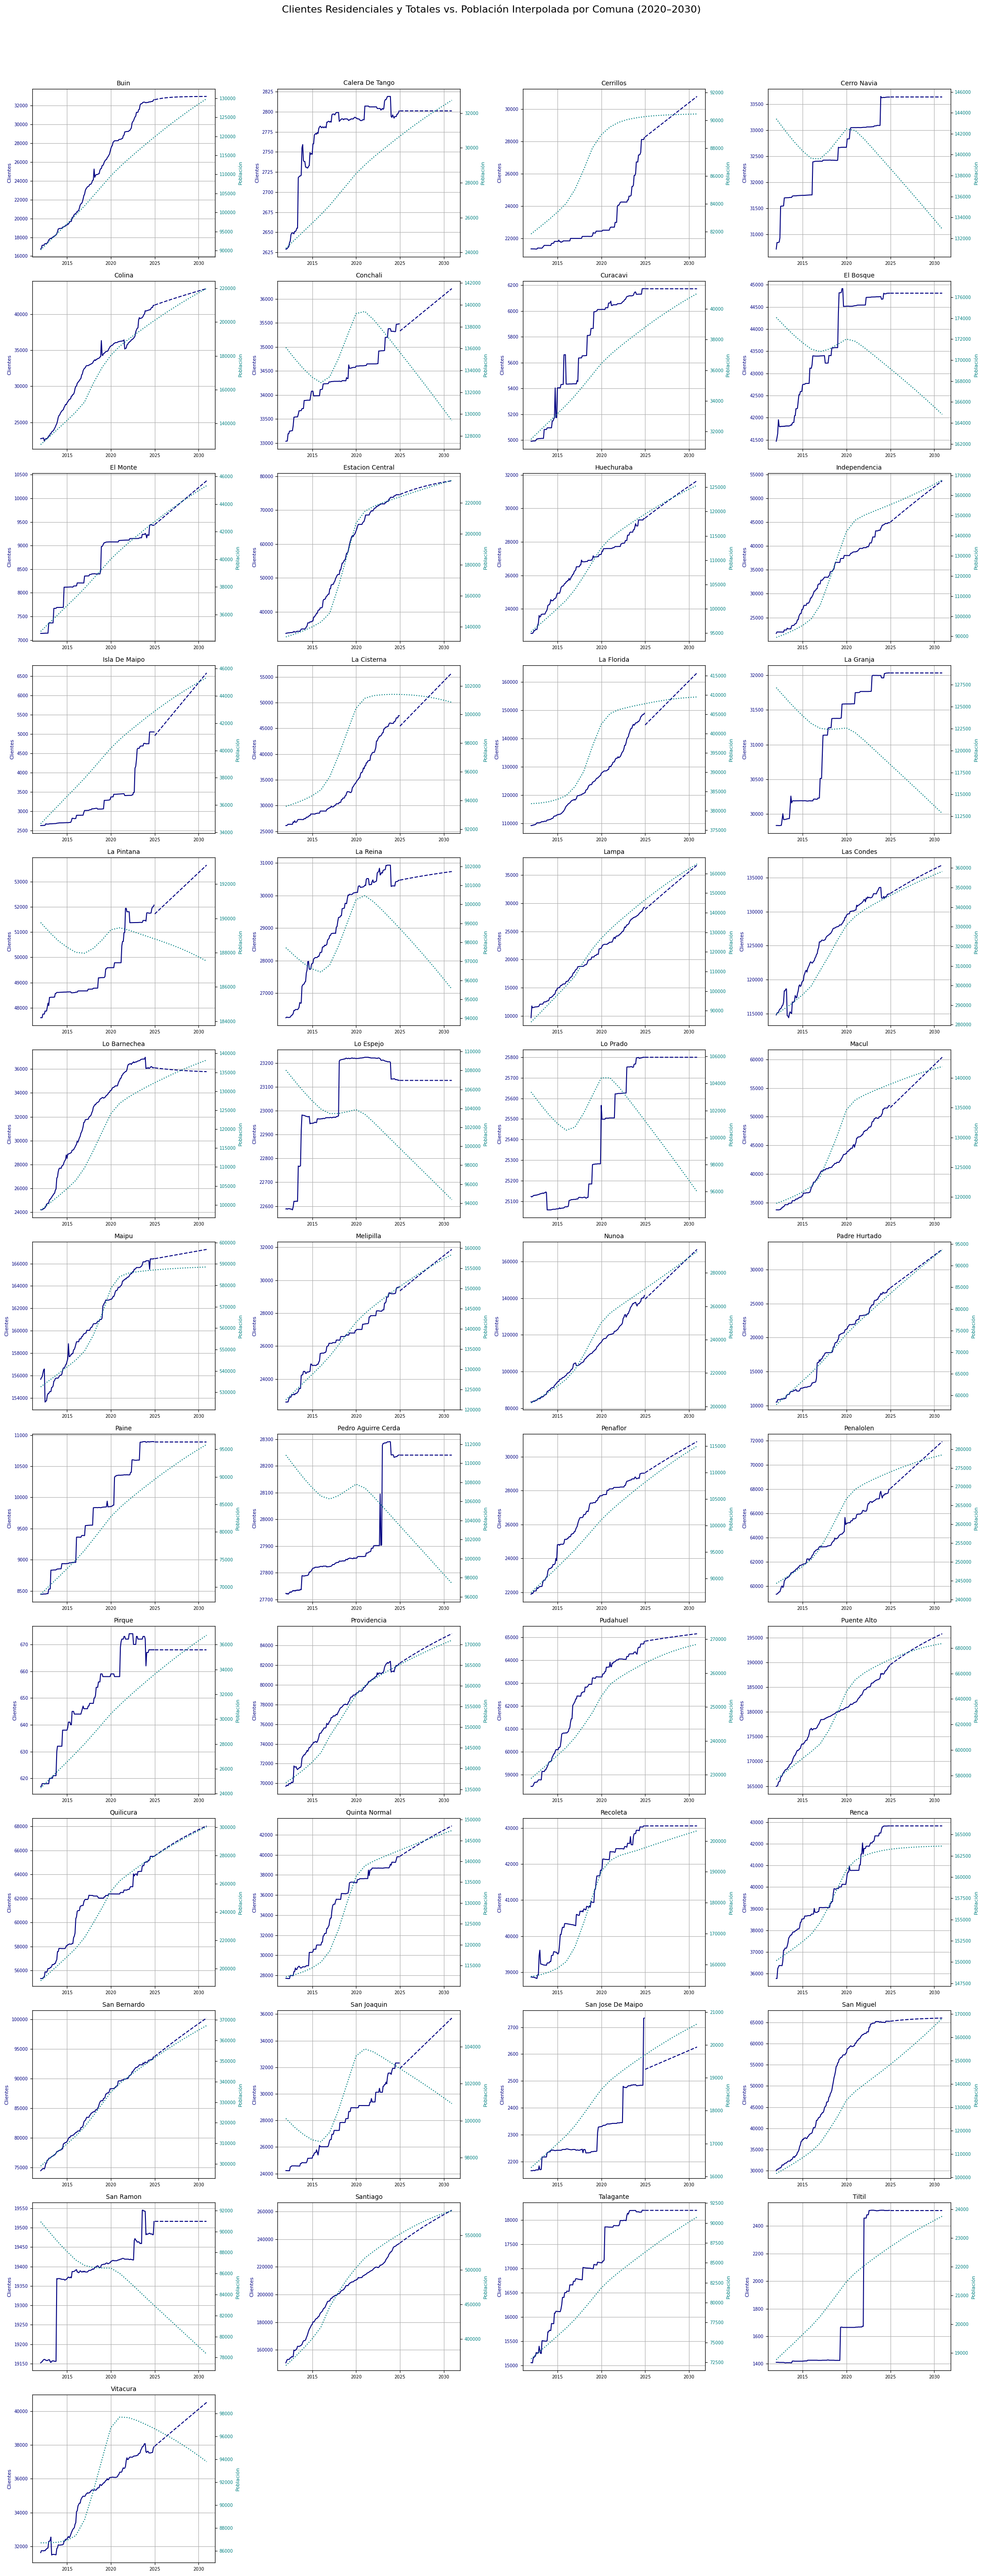

In [31]:
# Asegurar fechas en datetime
df_completo['Fecha'] = pd.to_datetime(df_completo['Fecha'])
df_mensual_interp['Fecha'] = pd.to_datetime(df_mensual_interp['Fecha'])

# Normalizar nombres de comuna
def normalizar_comuna(nombre):
    return unicodedata.normalize('NFKD', nombre).encode('ASCII', 'ignore').decode('utf-8').upper()

df_completo['Comuna'] = df_completo['Comuna'].apply(normalizar_comuna)
df_mensual_interp['Nombre Comuna'] = df_mensual_interp['Nombre Comuna'].apply(normalizar_comuna)

# 🔍 Filtrar solo residenciales y totales
df_filtrado = df_completo[df_completo['Grupo Cliente'].isin(['Residencial', 'Total'])]

# Agrupar por Fecha, Comuna, Origen (sumando clientes)
df_clientes_total = (
    df_filtrado
    .groupby(['Fecha', 'Comuna', 'Origen'], as_index=False)['Clientes']
    .sum()
)

# Comunas en común
comunas = sorted(set(df_clientes_total['Comuna']).intersection(df_mensual_interp['Nombre Comuna']))

# Configurar cuadrícula
n = len(comunas)
cols = 4
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5), sharex=False)
axes = axes.flatten()

for i, comuna in enumerate(comunas):
    ax1 = axes[i]

    # Filtrar clientes y población
    df_cli = df_clientes_total[df_clientes_total['Comuna'] == comuna]
    df_pob = df_mensual_interp[
        (df_mensual_interp['Nombre Comuna'] == comuna) &
        (df_mensual_interp['Fecha'] >= '2012-01-01') &
        (df_mensual_interp['Fecha'] <= '2030-12-31')
    ]

    if df_cli.empty or df_pob.empty:
        ax1.set_visible(False)
        continue

    # Separar histórico y proyección
    df_hist = df_cli[(df_cli['Origen'] == 'Histórico') & (df_cli['Fecha'] >= '2012-01-01')]
    df_proj = df_cli[(df_cli['Origen'] == 'Proyección') & (df_cli['Fecha'] <= '2030-12-31')]

    # Clientes (eje izquierdo)
    ax1.plot(df_hist['Fecha'], df_hist['Clientes'], label='Histórico', linestyle='-', color='navy', linewidth=1.5)
    ax1.plot(df_proj['Fecha'], df_proj['Clientes'], label='Proyección', linestyle='--', color='navy', linewidth=1.5)
    ax1.set_ylabel('Clientes', color='navy', fontsize=8)
    ax1.tick_params(axis='y', labelcolor='navy', labelsize=7)
    ax1.tick_params(axis='x', labelsize=7)
    ax1.xaxis.set_major_locator(mdates.YearLocator(5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Población (eje derecho)
    ax2 = ax1.twinx()
    ax2.plot(df_pob['Fecha'], df_pob['Poblacion'], color='teal', linewidth=1.5, linestyle=':', label='Población')
    ax2.set_ylabel('Población', color='teal', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='teal', labelsize=7)

    pob_min = df_pob['Poblacion'].min()
    pob_max = df_pob['Poblacion'].max()
    if np.isfinite(pob_min) and np.isfinite(pob_max):
        ax2.set_ylim(pob_min * 0.98, pob_max * 1.02)

    ax1.set_title(comuna.title(), fontsize=10)
    ax1.grid(True)

# Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Clientes Residenciales y Totales vs. Población Interpolada por Comuna (2020–2030)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Rescatar resultados

In [2]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
# Eliminar la columna 'M3 Ap'
df_limpio = df_proyecciones.drop(columns='M3 Ap')

# Reemplazar 'Total' por 'Residencial' en la columna 'Grupo Cliente'
df_limpio['Grupo Cliente'] = df_limpio['Grupo Cliente'].replace('Total', 'Residencial')

# Agrupar y sumar por las columnas especificadas
df_agrupado = df_limpio.groupby(['Fecha', 'Localidad', 'Nombre Corto', 'Grupo Cliente'], as_index=False).sum()

In [83]:
df_agrupado.to_csv('proyecciones_clientes_por localidad_empresa_cliente.csv', index=False)

In [84]:
df_agrupado.head()

Fecha         Localidad      Nombre Corto   Grupo Cliente  \
0 2025-01-01      AGUAS COLINA      AGUAS COLINA     Residencial   
1 2025-01-01  AGUAS CORDILLERA  AGUAS CORDILLERA  No Residencial   
2 2025-01-01  AGUAS CORDILLERA  AGUAS CORDILLERA     Residencial   
3 2025-01-01        ALTO LAMPA   AGUAS MANQUEHUE  No Residencial   
4 2025-01-01        ALTO LAMPA   AGUAS MANQUEHUE     Residencial   

        Clientes  
0    1796.420762  
1   18593.406865  
2  156501.057666  
3     271.739737  
4    1822.241036

In [85]:
df_agrupado[
    (df_agrupado['Nombre Corto'] == 'AGUAS ANDINAS') &
    (df_agrupado['Localidad'] == 'BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL') &
    (df_agrupado['Fecha'].dt.month == 1)
].groupby('Fecha', as_index=False)['Clientes'].sum()

Fecha      Clientes
0 2025-01-01  41903.211405
1 2026-01-01  42086.991537
2 2027-01-01  42185.694003
3 2028-01-01  42241.113778
4 2029-01-01  42274.442999
5 2030-01-01  42296.497474

In [44]:
# Eliminar la columna 'M3 Ap'
df_limpio = df_proyecciones.drop(columns=['M3 Ap', 'Nombre Corto', 'Grupo Cliente'])

# Agrupar y sumar por las columnas especificadas
df_agrupado_2 = df_limpio.groupby(['Fecha', 'Localidad'], as_index=False).sum()

df_agrupado_2.to_csv('proyecciones_clientes_por localidad.csv', index=False)

In [45]:
df_agrupado_2.head()

Fecha            Localidad       Clientes
0 2025-01-01         AGUAS COLINA    1796.420762
1 2025-01-01     AGUAS CORDILLERA  175094.464531
2 2025-01-01           ALTO LAMPA    2093.980774
3 2025-01-01  ALTOS DE CANTILLANA    1428.608269
4 2025-01-01         AP BARRANCAS    3661.167512

# Proyección dotación de consumo

## Preprocesamiento

In [73]:
#!pip install feature_engine

In [74]:
from feature_engine.creation import CyclicalFeatures
from tqdm.auto import tqdm

In [75]:
df_agua_final.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
2 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
3 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
4 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   

            Comuna   Grupo Cliente      M3 Ap  Clientes  
0             BUIN  No Residencial  149980.55    1110.0  
1             BUIN     Residencial  406371.24   16337.0  
2            PAINE  No Residencial   57303.35     484.0  
3            PAINE     Residencial  169485.26    8446.0  
4  CALERA DE TANGO  No Residencial   51454.45     268.0

In [76]:
df_dotacion_consumo_localidades = (
    df_agua_final
    .drop(columns=['Comuna', 'Grupo Cliente'])
    .groupby(['Fecha', 'Nombre Corto', 'Localidad'], as_index=False)['M3 Ap', 'Clientes']
    .mean()
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [77]:
df_dotacion_consumo = (
    df_agua_final
    .drop(columns='Comuna')
    .groupby(['Fecha', 'Nombre Corto', 'Localidad', 'Grupo Cliente'], as_index=False)['M3 Ap', 'Clientes']
    .sum()
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [78]:
df_dotacion_consumo_localidades['dotacion_consumo'] = df_dotacion_consumo_localidades['M3 Ap'] / df_dotacion_consumo_localidades['Clientes']
df_dotacion_consumo['dotacion_consumo'] = df_dotacion_consumo['M3 Ap'] / df_dotacion_consumo['Clientes']


In [79]:
df_dotacion_consumo_localidades = df_dotacion_consumo_localidades.drop(columns=["Clientes", "M3 Ap"])
df_dotacion_consumo = df_dotacion_consumo.drop(columns=["Clientes", "M3 Ap"])

In [80]:
df_dotacion_consumo_localidades['Año'] = df_dotacion_consumo_localidades['Fecha'].dt.year
df_dotacion_consumo_localidades['Mes'] = df_dotacion_consumo_localidades['Fecha'].dt.month
df_dotacion_consumo['Año'] = df_dotacion_consumo['Fecha'].dt.year
df_dotacion_consumo['Mes'] = df_dotacion_consumo['Fecha'].dt.month

In [81]:
df_dotacion_consumo_localidades.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   
2 2012-01-01  AGUAS ANDINAS                                       CURACAVI   
3 2012-01-01  AGUAS ANDINAS                            EL MONTE - EL PAICO   
4 2012-01-01  AGUAS ANDINAS                                  GRAN SANTIAGO   

   dotacion_consumo   Año  Mes  
0         29.690276  2012    1  
1         64.039434  2012    1  
2         25.154454  2012    1  
3         20.841526  2012    1  
4         26.242636  2012    1

In [82]:
df_dotacion_consumo.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
2 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   
3 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   
4 2012-01-01  AGUAS ANDINAS                                       CURACAVI   

    Grupo Cliente  dotacion_consumo   Año  Mes  
0  No Residencial        130.040088  2012    1  
1     Residencial         23.235948  2012    1  
2  No Residencial        191.994216  2012    1  
3     Residencial         50.995736  2012    1  
4     Residencial         25.154454  2012    1

In [83]:
df_dotacion_consumo_localidades[(df_dotacion_consumo_localidades["Localidad"]== "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") ]

Fecha   Nombre Corto                                      Localidad  \
0    2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
50   2012-02-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
100  2012-03-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
151  2012-04-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
202  2012-05-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
...         ...            ...                                            ...   
8380 2024-08-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
8438 2024-09-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
8496 2024-10-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
8554 2024-11-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
8612 2024-12-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   

      dotacion_consumo   Año  Mes  
0            29.690276  2012    1  
50           28.043307  2012    2  
100          28.316723  2012    3  
151          24.626753  2012    4  
202          22.514072  2012    5  
...                ...   ...  ...  
8380         19.530984  2024    8  
8438         19.752884  2024    9  
8496         20.184499  2024   10  
8554         22.160827  2024   11  
8612         23.884290  2024   12  

[156 rows x 6 columns]

In [84]:
df_dotacion_consumo[(df_dotacion_consumo["Localidad"]== "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") ]

Fecha   Nombre Corto  \
0     2012-01-01  AGUAS ANDINAS   
1     2012-01-01  AGUAS ANDINAS   
70    2012-02-01  AGUAS ANDINAS   
71    2012-02-01  AGUAS ANDINAS   
140   2012-03-01  AGUAS ANDINAS   
...          ...            ...   
12877 2024-10-01  AGUAS ANDINAS   
12969 2024-11-01  AGUAS ANDINAS   
12970 2024-11-01  AGUAS ANDINAS   
13062 2024-12-01  AGUAS ANDINAS   
13063 2024-12-01  AGUAS ANDINAS   

                                           Localidad   Grupo Cliente  \
0      BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
1      BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   
70     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
71     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   
140    BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
...                                              ...             ...   
12877  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   
12969  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
12970  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   
13062  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
13063  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   

       dotacion_consumo   Año  Mes  
0            130.040088  2012    1  
1             23.235948  2012    1  
70           120.436631  2012    2  
71            22.135273  2012    2  
140          130.777207  2012    3  
...                 ...   ...  ...  
12877         16.237439  2024   10  
12969         88.559219  2024   11  
12970         17.946262  2024   11  
13062         96.750724  2024   12  
13063         19.256644  2024   12  

[312 rows x 7 columns]

In [85]:
df_dotacion_consumo[(df_dotacion_consumo["Localidad"]== "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") & (df_dotacion_consumo["Grupo Cliente"]=="Residencial")]

Fecha   Nombre Corto  \
1     2012-01-01  AGUAS ANDINAS   
71    2012-02-01  AGUAS ANDINAS   
141   2012-03-01  AGUAS ANDINAS   
212   2012-04-01  AGUAS ANDINAS   
283   2012-05-01  AGUAS ANDINAS   
...          ...            ...   
12691 2024-08-01  AGUAS ANDINAS   
12784 2024-09-01  AGUAS ANDINAS   
12877 2024-10-01  AGUAS ANDINAS   
12970 2024-11-01  AGUAS ANDINAS   
13063 2024-12-01  AGUAS ANDINAS   

                                           Localidad Grupo Cliente  \
1      BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
71     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
141    BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
212    BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
283    BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
...                                              ...           ...   
12691  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
12784  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
12877  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
12970  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
13063  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   

       dotacion_consumo   Año  Mes  
1             23.235948  2012    1  
71            22.135273  2012    2  
141           21.742357  2012    3  
212           19.213446  2012    4  
283           17.627625  2012    5  
...                 ...   ...  ...  
12691         15.895272  2024    8  
12784         15.943958  2024    9  
12877         16.237439  2024   10  
12970         17.946262  2024   11  
13063         19.256644  2024   12  

[156 rows x 7 columns]

In [86]:
(
    df_dotacion_consumo_localidades[
        (df_dotacion_consumo_localidades["Localidad"] == "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") 
    ]
    .groupby("Año", as_index=False)["dotacion_consumo"]
    .agg(["mean", "max"])
    .rename(columns={"mean": "media", "max": "maximo"})
    .reset_index()
)

Año      media     maximo
0   2012  23.937517  29.690276
1   2013  24.316466  28.383073
2   2014  24.355366  30.191485
3   2015  23.831431  28.345601
4   2016  23.974017  27.718670
5   2017  23.870575  28.343417
6   2018  24.079400  28.039362
7   2019  23.631430  27.508635
8   2020  22.739175  26.540432
9   2021  23.348921  26.146455
10  2022  22.577982  25.447366
11  2023  21.755606  24.944666
12  2024  21.927050  24.342045

In [87]:
(
    df_dotacion_consumo[
        (df_dotacion_consumo["Localidad"] == "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") &
        (df_dotacion_consumo["Grupo Cliente"] == "Residencial")
    ]
    .groupby("Año", as_index=False)["dotacion_consumo"]
    .agg(["mean", "max"])
    .rename(columns={"mean": "media", "max": "maximo"})
    .reset_index()
)

Año      media     maximo
0   2012  18.957695  23.235948
1   2013  19.161252  22.488813
2   2014  19.098349  23.633650
3   2015  18.698829  22.430717
4   2016  18.864947  21.113475
5   2017  18.888871  22.274102
6   2018  19.175963  22.239645
7   2019  18.757906  21.699139
8   2020  18.562441  21.081632
9   2021  19.156451  21.358815
10  2022  18.307920  20.579802
11  2023  17.687289  19.819314
12  2024  17.854124  20.234716

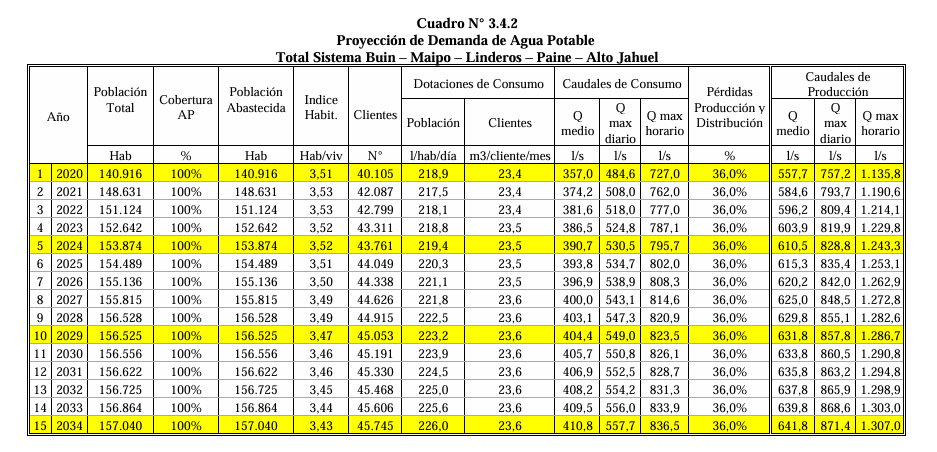

In [88]:
df_dotacion_consumo.to_csv('df_dotacion_consumo.csv', index=False)

In [89]:
df_dotacion_consumo_localidades.to_csv('df_dotacion_consumo_localidades.csv', index=False)

## Proyección